In [1]:
from pycaret.classification import * 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from matplotlib import rc
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'Malgun Gothic'
%matplotlib inline

# 데이터 불러오기

In [3]:
data_origin=pd.read_csv('wildfire_최종기본데이터 (1).csv',index_col=0)

In [4]:
# 거리 22km 이상인 데이터는 쓰지말자
data_origin_test = data_origin[data_origin['거리(km)_aws']<=22]

In [5]:
# 인덱스 초기화 해주기
data_origin_test=data_origin_test.reset_index(drop=True)

In [6]:
# 연도별로 정렬해주기 -> 2021년과 2022년을 정확히 구별하기 위해
data_origin_test=data_origin_test.sort_values('년')

In [7]:
# 2021년 2022년 인덱스 뒤바뀌었을수있어서 다시 한번 인덱스 정리
data_origin_test=data_origin_test.reset_index(drop=True)

사용하지 않는 피쳐 드롭해주기

In [8]:
data_origin_test.drop(['평균기온(°C)_asos','거리(km)_aws','거리(km)_asos','평균 풍속(m/s)_asos','일강수량(mm)_asos','월','일','주소','경도','위도','지점_aws','지점_asos','지점명_asos','지점명_aws'],axis=1,inplace=True)

## train,test 2022년기준으로 자르기

In [9]:
data_origin_test.iloc[9362:9367]

,발생지역,년,피해면적,평균 상대습도(%)_asos,평균기온(°C)_aws,일강수량(mm)_aws,평균 풍속(m/s)_aws,season,실효습도
9362,경기,2021,0.05,60.1,5.0,0.0,0.7,spring,45.368724
9363,강원,2021,0.02,52.6,18.6,0.0,1.2,spring,49.624608
9364,경남,2021,0.10,40.6,-3.7,0.0,3.1,others,50.221332
9365,경북,2021,0.10,43.8,12.0,0.0,1.0,spring,38.512032
9366,경기,2022,0.13,70.0,15.6,0.0,1.4,spring,54.784107


- 9365까지 2021년 

In [10]:
data_origin_test['피해면적'].describe()

count    10008.000000
mean         4.319771
std        171.736506
min          0.000000
25%          0.030000
50%          0.100000
75%          0.400000
max      16301.980000
Name: 피해면적, dtype: float64

In [11]:
for i in range(len(data_origin_test)):
    if data_origin_test['피해면적'][i]<0.05 :
        data_origin_test['피해면적'][i]=1
    elif (data_origin_test['피해면적'][i]>=0.05) & (data_origin_test['피해면적'][i]<0.15) :
        data_origin_test['피해면적'][i]=2
    elif (data_origin_test['피해면적'][i]>=0.1) & (data_origin_test['피해면적'][i]<0.45) :
        data_origin_test['피해면적'][i]=3
    else :
        data_origin_test['피해면적'][i]=4

In [12]:
data_origin_test = pd.get_dummies(data = data_origin_test, columns = ['season'], prefix = 'season')

In [13]:
df = data_origin_test

In [14]:
data_origin_test.drop(['발생지역','년'],axis=1,inplace=True)

In [15]:
df = df.rename(columns={df.columns[0]: '위험도',df.columns[1]: '평균상대습도(%)', df.columns[2]: '평균기온', df.columns[3]: '일강수량(mm)', df.columns[4]: '평균풍속(m/s)',df.columns[5]: '실효습도(%)', df.columns[6]: '가을', df.columns[7]: '여름겨울', df.columns[8]: '봄'})

In [16]:
heatmap_data = df[['위험도','평균상대습도(%)', '평균기온', '일강수량(mm)', '평균풍속(m/s)', '실효습도(%)', '가을', '여름겨울',
       '봄']]

<AxesSubplot:>

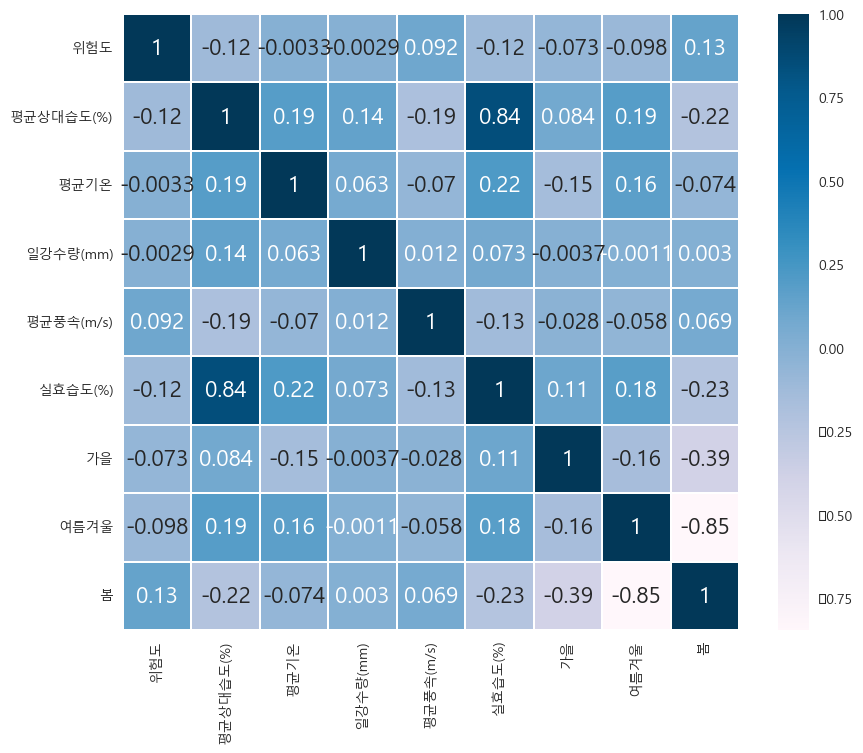

In [17]:
colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
           square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [18]:
corr_df = df.corr()
s = corr_df.unstack()
df_corr = pd.DataFrame(s[s < 1].sort_values(ascending=False), columns=['corr'])
df_corr.style.background_gradient(cmap='viridis')

,,corr
실효습도(%),평균상대습도(%),0.844497
평균상대습도(%),실효습도(%),0.844497
평균기온,실효습도(%),0.218243
실효습도(%),평균기온,0.218243
평균상대습도(%),평균기온,0.192259
평균기온,평균상대습도(%),0.192259
여름겨울,평균상대습도(%),0.190722
평균상대습도(%),여름겨울,0.190722
여름겨울,실효습도(%),0.182561
실효습도(%),여름겨울,0.182561


In [19]:
df

,위험도,평균상대습도(%),평균기온,일강수량(mm),평균풍속(m/s),실효습도(%),가을,여름겨울,봄
0,3.0,74.9,3.9,0.0,4.2,59.873058,0,1,0
1,4.0,39.4,14.8,0.0,1.6,39.123108,0,0,1
2,3.0,39.4,13.5,0.0,1.6,39.123108,0,0,1
3,1.0,41.1,15.7,0.0,2.2,34.927743,0,0,1
4,3.0,45.0,9.3,0.0,2.2,43.160127,0,0,1
...,...,...,...,...,...,...,...,...,...
10003,4.0,54.9,5.1,0.0,2.1,43.060410,0,0,1
10004,2.0,33.3,4.2,0.0,3.6,37.051293,0,0,1
10005,1.0,47.4,7.8,0.0,1.9,40.223292,0,0,1
10006,1.0,52.9,5.2,0.0,1.2,48.460068,0,0,1


In [20]:
df['실효습도(%)']=round(df['실효습도(%)'],2)

In [21]:
df['위험도'].value_counts()

2.0    2730
1.0    2694
4.0    2464
3.0    2120
Name: 위험도, dtype: int64

비가 약간이라도 오면 산불이 나기 어렵다고 판단

In [22]:
for i in range(len(df)):
    if df['일강수량(mm)'][i]==0.0:
        df['일강수량(mm)'][i]=0
    else:
        df['일강수량(mm)'][i]=1

<AxesSubplot:xlabel='실효습도(%)', ylabel='Density'>

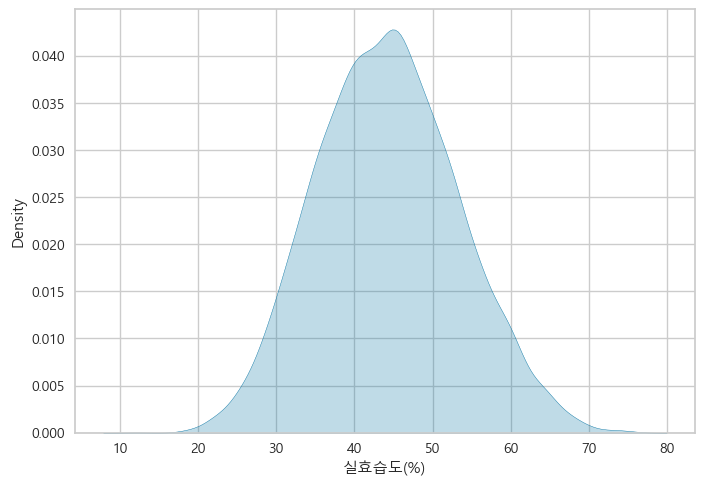

In [23]:
sns.kdeplot(df['실효습도(%)'],shade=True)

In [24]:
df.describe()

,위험도,평균상대습도(%),평균기온,일강수량(mm),평균풍속(m/s),실효습도(%),가을,여름겨울,봄
count,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000,10008.000000
mean,2.435052,50.926139,9.388669,0.048861,1.938139,44.204649,0.068545,0.254596,0.676859
std,1.129905,13.282696,7.710637,0.215588,1.216536,9.059409,0.252692,0.435656,0.467700
min,1.000000,10.400000,-14.700000,0.000000,0.000000,12.160000,0.000000,0.000000,0.000000
25%,1.000000,41.400000,3.800000,0.000000,1.200000,37.740000,0.000000,0.000000,0.000000
50%,2.000000,50.400000,9.200000,0.000000,1.600000,44.080000,0.000000,0.000000,1.000000
75%,3.000000,59.900000,14.800000,0.000000,2.300000,50.290000,0.000000,1.000000,1.000000
max,4.000000,99.000000,32.100000,1.000000,18.500000,75.620000,1.000000,1.000000,1.000000


In [25]:
df['일강수량(mm)'].value_counts()

0.0    9519
1.0     489
Name: 일강수량(mm), dtype: int64

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [27]:
train=df.iloc[:9365]
test=df.iloc[9365:]

In [28]:
target = train['위험도'][:len(train)]

In [29]:
print(train.shape, test.shape, target.shape)

(9365, 9) (643, 9) (9365,)


In [30]:
train.drop(['위험도'],axis=1,inplace=True)

In [31]:
target.value_counts()

2.0    2565
1.0    2525
4.0    2285
3.0    1990
Name: 위험도, dtype: int64

In [32]:
train

,평균상대습도(%),평균기온,일강수량(mm),평균풍속(m/s),실효습도(%),가을,여름겨울,봄
0,74.9,3.9,0.0,4.2,59.87,0,1,0
1,39.4,14.8,0.0,1.6,39.12,0,0,1
2,39.4,13.5,0.0,1.6,39.12,0,0,1
3,41.1,15.7,0.0,2.2,34.93,0,0,1
4,45.0,9.3,0.0,2.2,43.16,0,0,1
...,...,...,...,...,...,...,...,...
9360,58.3,12.4,0.0,1.2,47.46,0,0,1
9361,82.1,12.1,1.0,1.2,49.58,0,0,1
9362,60.1,5.0,0.0,0.7,45.37,0,0,1
9363,52.6,18.6,0.0,1.2,49.62,0,0,1


In [33]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.2, stratify=target,random_state=42) 

print(X_train.shape, X_test.shape,  y_train.shape, y_test.shape )

(7492, 8) (1873, 8) (7492,) (1873,)


In [34]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier(n_estimators=100,random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [35]:
prediction = model.predict(X_test)
print("Accuracy is: ", accuracy_score(prediction, y_test))
acc_RF=accuracy_score(prediction, y_test)

Accuracy is:  0.3224773091297384


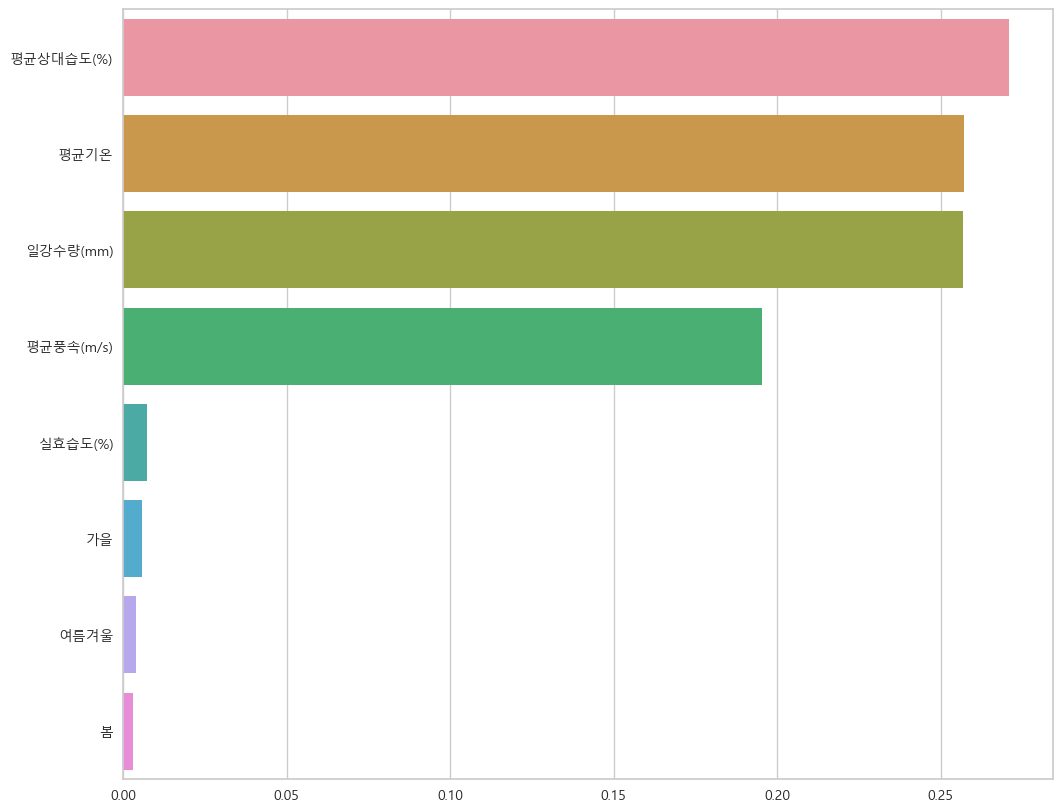

In [36]:
feature_importances = model.feature_importances_

ft_importances = pd.Series(feature_importances, index = X_train.columns)
ft_importances = ft_importances.sort_values(ascending=False)

plt.figure(figsize=(12,10))
sns.barplot(x=ft_importances, y= X_train.columns)
plt.show()